In [1]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

Using cupy


In [25]:
@dataclass
class Config:
    nx: int = 400
    ny: int = 200
    steps: int = 50000
    output_stride: int = 5000
    molecular_weights: tuple[float, float, float] = (30, 30)
    left_frac: tuple[float, float, float] = (0.01, 0.99) # pressure fraction
    right_frac: tuple[float, float, float] = (0.01, 0.99)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 5
    frames_dir: str = "demo_frames/three_species_mixing"

In [26]:
def initialise_chamber(config: Config):
    nx, ny = config.nx, config.ny
    species = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float64)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float64)
    mid = nx // 2
    left = xp.array(config.left_frac, dtype=xp.float64) * config.total_pressure
    right = xp.array(config.right_frac, dtype=xp.float64) * config.total_pressure
    for s in range(species):
        psigma[s, :mid, :] = left[s]
        psigma[s, mid:, :] = right[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    # Initial populations from equilibrium with zero velocity
    f = xp.zeros((species, 9, nx, ny), dtype=xp.float64)
    ux_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    uy_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [4]:
def main(non_absorb_mask, bc_top, bc_bottom):
    cfg = Config()
    out_dir = 'demo_frames'

    f, phi = initialise_chamber(cfg)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float64)

    #extra_thickness = []
    error_history = []

    for step in tqdm(range(cfg.steps + 1)):
        f_old = xp.copy(f)

        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)

            #thickness = calculate_boundary_concentration(f)
            #extra_thickness.append(to_numpy(thickness))
            #plot_vertical_concentration(f)
        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream_BC_full, step,
                     non_absorb_mask, bc_top, bc_bottom)
        error = to_numpy(xp.mean(abs(f-f_old)))
        error_history.append(error)

    print(f"Saved frames to {out_dir}")

    return f, error_history

In [5]:
def calculate_boundary_concentration(f):

    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)

    concentration_profile = to_numpy(rho_s[0, :, 0])
    base_concentration = np.min(concentration_profile)
    extra_thickness = concentration_profile - base_concentration #+ 1e-4

    normalized_extra_thickness = extra_thickness/base_concentration
    '''
    plt.scatter(np.arange(f.shape[2])[to_numpy(non_absorb_mask) == 0], extra_thickness[to_numpy(non_absorb_mask) == 0], s = 1)
    '''

    return normalized_extra_thickness

In [6]:
def plot_vertical_concentration(f):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)

    concentration_vertical = to_numpy(rho_s[0, 50, :])

    plt.plot(np.arange(200), concentration_vertical)
    plt.show()

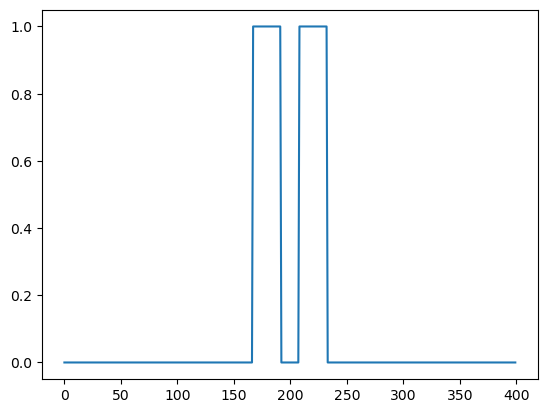

In [10]:
absorption_coefficient = 50

non_absorb_mask = xp.zeros(Config.nx, dtype=bool)
gap = 16
width = 25
non_absorb_mask[Config.nx//2 - gap//2 - width: Config.nx//2- gap//2] = True
non_absorb_mask[Config.nx//2 + gap//2 : Config.nx//2 + gap//2 + width] = True

plt.plot(to_numpy(non_absorb_mask))

#bottom boundary
b1 = xp.array([absorption_coefficient, 0, 0]) # 1 / absorption
b2 = xp.array([1, 1])
b3 = xp.array([0, 89.1]) # stable concentration
reflection_boundary = np.array([0, 1]) # which component has no-slip wall BC

bc_bottom = (b1, b2, b3, reflection_boundary)

# top boundary
b1 = xp.array([0, 0])
b2 = xp.array([1, 1])
b3 = xp.array([0.9, 89.1])
reflection_boundary = np.array([0, 0, 0])

bc_top = (b1, b2, b3, reflection_boundary)


In [ ]:
#%prun -D mslbm.pstat f = main()
f, error_history = main(non_absorb_mask, bc_top, bc_bottom)

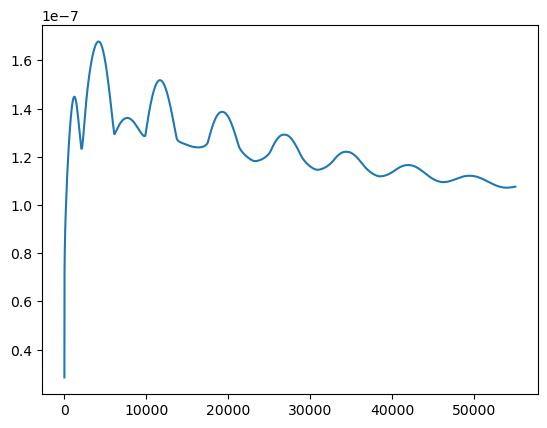

In [36]:
plt.plot(error_history)

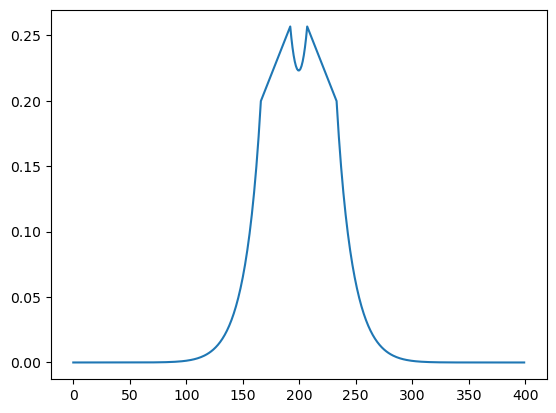

In [25]:
thickness_profile = calculate_boundary_concentration(f)
plt.plot(np.arange(f.shape[2])[to_numpy(non_absorb_mask) == 0], thickness_profile[to_numpy(non_absorb_mask) == 0])

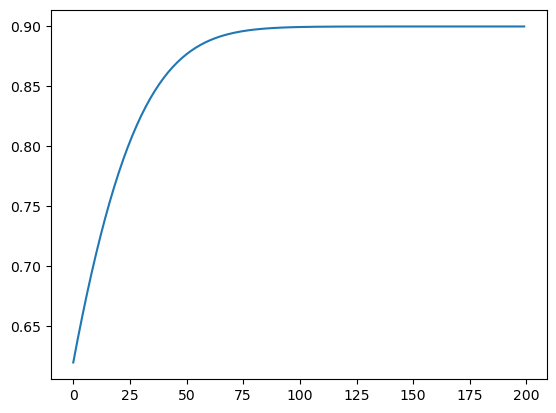

In [27]:
phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
concentration_vertical = to_numpy(rho_s[0, 0, :])
fit_steps = 5
slope, b = np.polyfit(np.arange(fit_steps), concentration_vertical[:fit_steps], 1)
measured_absorption = slope/concentration_vertical[0]

plt.plot(concentration_vertical)

In [22]:
from joblib import Parallel, delayed

def _single_run(absorption_rate):

    non_absorb_mask = xp.zeros(Config.nx, dtype=bool)
    gap = 32
    width = 40
    non_absorb_mask[Config.nx//2 - gap//2 - width: Config.nx//2- gap//2] = True
    non_absorb_mask[Config.nx//2 + gap//2 : Config.nx//2 + gap//2 + width] = True
    #bottom boundary
    b1 = xp.array([absorption_rate, 0, 0]) # 1 / absorption
    b2 = xp.array([1, 1])
    b3 = xp.array([0, 89.1]) # stable concentration
    reflection_boundary = np.array([0, 1]) # which component has no-slip wall BC

    bc_bottom = (b1, b2, b3, reflection_boundary)

    # top boundary
    b1 = xp.array([0, 0])
    b2 = xp.array([1, 1])
    b3 = xp.array([0.9, 89.1])
    reflection_boundary = np.array([0, 0, 0])

    bc_top = (b1, b2, b3, reflection_boundary)
    f, error_history = main(non_absorb_mask, bc_top, bc_bottom)
    #thickness_profile = calculate_boundary_concentration(f)

    return f

def parameter_sweep_parallel(num, n_jobs=2, backend="loky"):
    a = np.linspace(-3.5, -0.5, num = num, endpoint = True)
    absorption_rates = 1/np.power(10, a)

    absorption_rates = np.linspace(5, 150, num = num, endpoint = True)
    print(f"absorption rates: {absorption_rates}")

    results = Parallel(n_jobs=n_jobs, backend=backend)(
        delayed(_single_run)(absorption_rate)
        for absorption_rate in absorption_rates
    )

    f_results = results
    return absorption_rates, f_results

In [27]:
absorption_rates, f_results = parameter_sweep_parallel(num = 10, n_jobs=5, backend="loky")
# n = 3, 47 min
# n = 5, 42 min
f_results_cpu = to_numpy(xp.array(f_results))
np.save("f_results_cpu", f_results_cpu)

absorption rates: [  5.          21.11111111  37.22222222  53.33333333  69.44444444
  85.55555556 101.66666667 117.77777778 133.88888889 150.        ]


In [13]:
f_results_cpu = to_numpy(xp.array(f_results))
np.save("f_results_cpu", f_results_cpu)

[  5.          21.11111111  37.22222222  53.33333333  69.44444444
  85.55555556 101.66666667 117.77777778 133.88888889 150.        ]


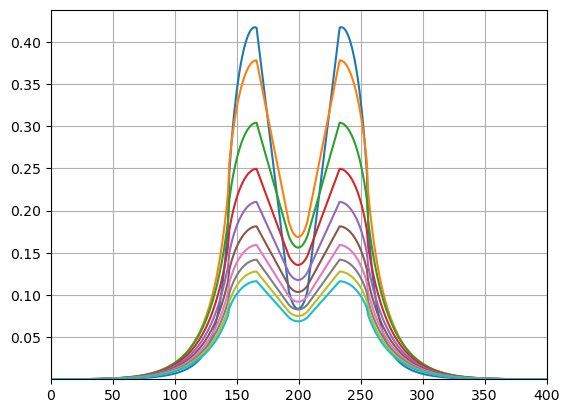

In [38]:
print(absorption_rates)
measured_absorption_curve = []
for i in range(10):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f_results[i], phi)

    concentration_profile = to_numpy(rho_s[0, :, 0])
    base_concentration = np.min(concentration_profile)
    extra_thickness = concentration_profile - base_concentration + 1e-5

    normalized_extra_thickness = extra_thickness/base_concentration

    plt.plot(np.arange(len(concentration_profile))[to_numpy(non_absorb_mask) == 0], extra_thickness[to_numpy(non_absorb_mask) == 0], label=f"{absorption_rates[i]:.2g}")

    #plt.plot(np.arange(len(concentration_profile))[to_numpy(non_absorb_mask) == 0], concentration_profile[to_numpy(non_absorb_mask) == 0], label=f"{absorption_rates[i]:.2g}")


plt.xlim(0, len(concentration_profile))
#plt.xlim(200, 300)
plt.ylim(bottom = 1e-5)
#plt.ylim(top = 1)

#plt.yscale('log')
plt.grid()
#plt.legend()
plt.show()


[  5.          21.11111111  37.22222222  53.33333333  69.44444444
  85.55555556 101.66666667 117.77777778 133.88888889 150.        ]


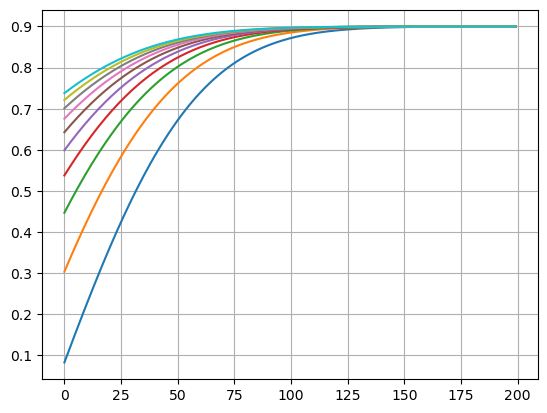

In [35]:
print(absorption_rates)
measured_absorption_curve = []
for i in range(10):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f_results[i], phi)

    concentration_vertical = to_numpy(rho_s[0, 50, :])

    plt.plot(np.arange(200), concentration_vertical)

    fit_steps = 5
    slope, b = np.polyfit(np.arange(fit_steps), concentration_vertical[:fit_steps], 1)
    measured_absorption = slope/concentration_vertical[0]
    measured_absorption_curve.append(measured_absorption)

#plt.yscale("log")
plt.grid()
plt.show()


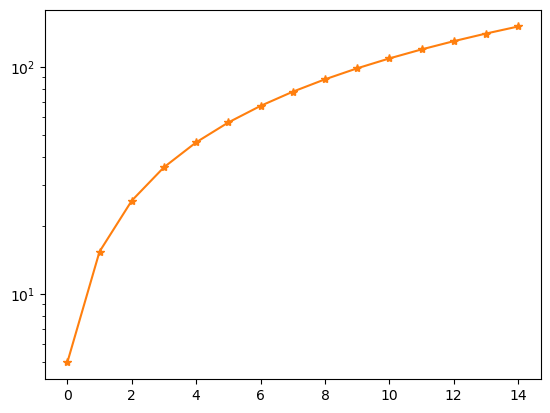

In [17]:
plt.plot(measured_absorption_curve, marker = '.')
plt.plot(absorption_rates, marker = '*')
plt.yscale('log')

0.45090003589450633


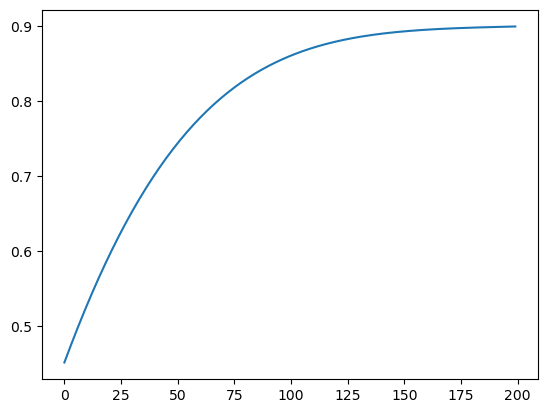

In [18]:
i = 10
phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f_results[i], phi)

concentration_vertical = to_numpy(rho_s[0, 300, :])
print(np.min(concentration_vertical))
plt.plot(concentration_vertical)

0.45090003589450633


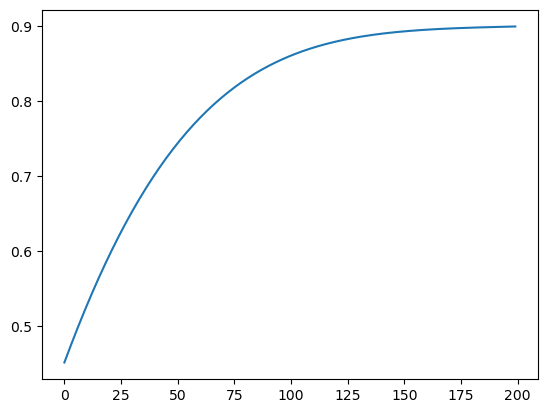

In [19]:
i = 0
phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f_results[i], phi)

concentration_vertical = to_numpy(rho_s[0, 300, :])
print(np.min(concentration_vertical))
plt.plot(concentration_vertical)